# Create an ESN for sepsis shared features (trial 1)

## Load ICU sepsis data log

In [90]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math as m
from os import listdir
%matplotlib inline
path = '../training/'

gkfold_split = 10

In [83]:
fnames = listdir(path)  
if 'README.md' in paths:
    fnames.remove('README.md')
fnames[-1]

'README.md'

In [81]:
# Choose patient sample
sample_num = len(paths)
sample_num

40336

In [86]:
# Import and print dataframe layout
def loadICUdata(fname, printdf = False):
    df = pd.read_csv(fname, sep = '|')
    #print(fname, ' file:')
    if printdf:
        print(df)
    return df

df = loadICUdata(path + fnames[0], False)
# df

## Check sepsis labels for ALL patients

In [4]:
# get the sepsis label value
def get_sepsislabel(df):
    sl = df[["SepsisLabel"]]
    count = df['SepsisLabel'].value_counts()
    count_healthy = -1
    count_sep = -1
    
    if len(count) == 2:
        count_sep = count[1]
        count_healthy = count[0]
        
    elif len(count) == 1:
        if sl.values[0] == 0:
            count_healthy = count.values[0]
        elif sl.values[0] == 1:
            count_sep = count.values[0]
    return sl, count_healthy, count_sep


In [5]:
count = df['SepsisLabel'].value_counts()
count.values
len(count)
sl, ch, cs = get_sepsislabel(df)
len(sl)

260

In [6]:
# Print result
sl, ch, cs = get_sepsislabel(df) 
print('patient {:d}, {:d} {:d} {:2.2f}%'.format(sample_num, ch, cs, 100*cs/len(sl)))

patient 785, 260 -1 -0.38%


## Loop study, sepsis presence

In [87]:
# Run in a loop and get a sepsis presence report
SL = []    #Sepsis labels
CH = []    #Healthy hours count
CS = []    #Sepsis hours count
CSCH = []  #Percentage cs/(cs+ch)
DATA = []  #DATA structure
for i in range(sample_num):
    df = loadICUdata(path + fnames[i], False)
    DATA.append(df) 
    sl, ch, cs = get_sepsislabel(df) 
    SL.append(sl)
    CH.append(ch)
    CS.append(cs)
    if cs != -1 and ch != -1:
        csch = 1.0*cs/(cs + ch)
    elif cs == -1:
        csch = 0
    elif ch == -1:
        csch = 1
    CSCH.append(csch)
    
CSCH = np.array(CSCH)

In [88]:
# Count sepsis patients
print(CSCH, np.count_nonzero(CSCH))

[0. 0. 0. ... 0. 0. 0.] 2932


In [89]:
sepsis_idx = np.where(CSCH!=0)

## Matrix Sepsis

In [10]:
def get_dfmaxcount(list_of_lists):
    maxval = -1
    maxval_i = -1
    for i in range(len(list_of_lists)):
        val = list_of_lists[i].count(axis = 0)[0]
        if val > maxval:
            maxval = val
            maxval_i = i
    return maxval, maxval_i

In [11]:
# get max val in SepsisLabel count and idx position
mv, mvi = get_dfmaxcount(SL)

In [12]:
mv, mvi

(336, 1921)

In [13]:
# Initialize sepsis matrix
sepsis_matrix = -1 * np.ones((len(SL),mv), dtype=int)
for i in range(len(SL)):
    sepsis_matrix[i][0:(SL[i].count(axis = 0)[0])] = (SL[i].values).flatten()
np.shape(sepsis_matrix)

(5000, 336)

## Sepsis keys for the ESN

In [14]:
sepsis_idx = np.where(CSCH!=0)
healthy_idx = np.where(CSCH==0) 

In [15]:
# We use features (9) shared by all sepsis patients
s_keys = []
with open(path + paths[0], 'r') as f:
    header = f.readline().strip()
    s_keys = header.split('|')
    
# s_keys = ['HR', 'O2Sat', 'SBP', 'MAP', 'DBP', 'Age', 'Gender', 'HospAdmTime', 'ICULOS'] #, 'SepsisLabel']
# s_keys = ['HR', 'O2Sat', 'SBP', 'MAP', 'DBP', 'Age', 'Gender', 'ICULOS']#'HospAdmTime', 'ICULOS'] #, 'SepsisLabel']
# s_keys = ['HR', 'O2Sat', 'SBP', 'MAP', 'DBP', 'Age', 'Gender', 'HospAdmTime', 'ICULOS', 'SepsisLabel']
# s_keys = ['Age', 'Gender', 'SepsisLabel']
# s_keys = ['SepsisLabel']
s_keys = ['HR', 'O2Sat', 'SBP', 'MAP', 'DBP', 'Age', 'Gender', 'HospAdmTime', 'ICULOS'] #, 'SepsisLabel']
type(s_keys)
len(s_keys)

9

In [16]:
DATA[0]["HR"].values

array([  nan,  93. ,  91. ,  93. ,  93. ,   nan,  91.5,  94. ,  94. ,
       102. , 106. , 107. , 102. ,  98. ,  95. , 105. ,  94. ,  98. ,
        98. , 105. ,  96. , 102. , 105. , 107. ])

In [17]:
# Feature matrix (removing nan)
feature_matrix = []
patient = []
sepsis_label = []
for i in range(5000):
    initval = 0
    A = initval * np.ones((DATA[i].shape[0],len(s_keys)), dtype=np.double)
    j = 0
    for key in s_keys:
        A[:,j] = DATA[i][key].values
        j = j + 1
       # print (i, key, j)
    A = np.nan_to_num(A)
    sep_lab = (DATA[i]["SepsisLabel"].values).reshape(-1,1)
    if i==0:
        feature_matrix=(A)
        patient = i*np.ones((DATA[i].shape[0],1),dtype=np.int)
        sepsis_label = sep_lab
        
    else: 
        feature_matrix = np.vstack((feature_matrix, A))
        patient = np.vstack((patient, i*np.ones((DATA[i].shape[0],1),dtype=np.int)))
        sepsis_label = np.vstack((sepsis_label, sep_lab))

In [18]:
type(feature_matrix[0])

numpy.ndarray

In [19]:
feature_matrix
np.shape(feature_matrix)

(188453, 9)

In [20]:
# Keep a raw copy
raw_feature_matrix = np.copy(feature_matrix)

In [21]:
patient
np.shape(patient)

(188453, 1)

In [22]:
sepsis_label
np.shape(sepsis_label)

(188453, 1)

In [23]:
# Single entry example
i_e = 90000
print(patient[i_e])
print(feature_matrix[i_e,:])
print(sepsis_label[i_e])


[2378]
[ 89.    98.   120.    70.    50.    62.     0.    -1.38  22.  ]
[0]


37 entries x 9


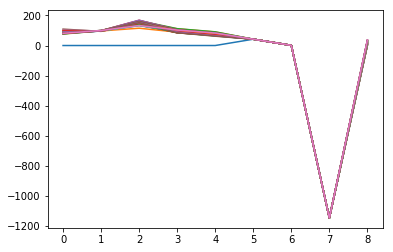

In [24]:
i_pat = 6

def plot_patient_features(n_pat, features, patient_array):
    plot_j = np.where(patient == n_pat)[0]
    for j in range (len(plot_j)):
        plt.plot(features[plot_j[j],:])    
    print(len(plot_j), "entries x", np.shape(features)[1])
    return

def print_patient_features(n_pat, features, patient_array):
    print("Patient", n_pat)
    print_j = np.where(patient == n_pat)[0]
    for j in range (len(print_j)):
        print(features[print_j[j],:])    
    return

plot_patient_features(i_pat, feature_matrix, patient)

## Preprocess features (log(-HospAdmTime-1))

In [25]:
feature_matrix= np.copy(raw_feature_matrix)
feat_i = s_keys.index('HospAdmTime')

In [26]:
print(np.min(raw_feature_matrix[:,feat_i]), np.max(raw_feature_matrix[:,feat_i]))
argmin = (np.argmin(raw_feature_matrix[:,feat_i]))
print(argmin, patient[argmin])

# for i in range(len(raw_feature_matrix[:,feat_i])):
#     print(raw_feature_matrix[i,feat_i])

-5366.86 0.0
30281 [784]


HospAdmTime


7

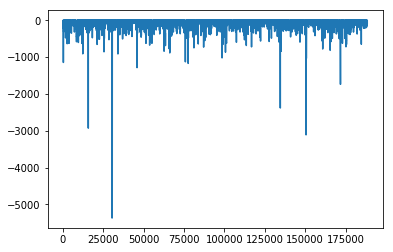

In [27]:
print (s_keys[7])
plt.plot(feature_matrix[:,7])
feat_i

In [28]:
change_i = np.where(raw_feature_matrix[:,feat_i]!=np.nan)[0]
print(len(change_i))
change_i

188453


array([     0,      1,      2, ..., 188450, 188451, 188452], dtype=int64)

In [29]:
change_feature = True
if change_feature:
    feature_matrix[change_i,feat_i] = np.log(1-np.copy(raw_feature_matrix[change_i,feat_i]))
    # for i in range(len(change_i)):
    for i in range(50):
        print(raw_feature_matrix[change_i[i],feat_i],feature_matrix[change_i[i],feat_i])

-214.64 5.373610350583468
-214.64 5.373610350583468
-214.64 5.373610350583468
-214.64 5.373610350583468
-214.64 5.373610350583468
-214.64 5.373610350583468
-214.64 5.373610350583468
-214.64 5.373610350583468
-214.64 5.373610350583468
-214.64 5.373610350583468
-214.64 5.373610350583468
-214.64 5.373610350583468
-214.64 5.373610350583468
-214.64 5.373610350583468
-214.64 5.373610350583468
-214.64 5.373610350583468
-214.64 5.373610350583468
-214.64 5.373610350583468
-214.64 5.373610350583468
-214.64 5.373610350583468
-214.64 5.373610350583468
-214.64 5.373610350583468
-214.64 5.373610350583468
-214.64 5.373610350583468
-123.17 4.821651594428751
-123.17 4.821651594428751
-123.17 4.821651594428751
-123.17 4.821651594428751
-123.17 4.821651594428751
-123.17 4.821651594428751
-123.17 4.821651594428751
-123.17 4.821651594428751
-123.17 4.821651594428751
-123.17 4.821651594428751
-123.17 4.821651594428751
-123.17 4.821651594428751
-123.17 4.821651594428751
-123.17 4.821651594428751
-123.17 4.82

0.0 8.588184597834516


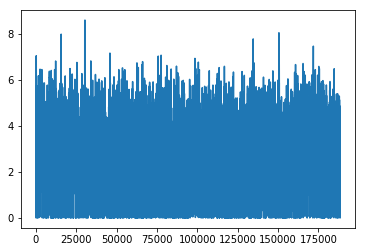

In [30]:
print(np.min(feature_matrix[:,feat_i]), np.max(feature_matrix[:,feat_i]))
plt.plot(feature_matrix[change_i,feat_i])

In [31]:
print(np.min(feature_matrix), np.max(feature_matrix[:,:19]))

0.0 336.0


In [32]:
np.shape(feature_matrix[:,:5])

(188453, 5)

## Mapminmax normalise scale per feature per patient

In [33]:
norm_feat_pat = False
if norm_feat_pat:
    for i in range(5000):
        i_pat = np.where(patient==i)[0]
        scaler = MinMaxScaler()
        scaler.fit(feature_matrix[i_pat,:5])
        feature_matrix[i_pat,:5] = scaler.transform(feature_matrix[i_pat,:5])
        
# Per single feature
#         for j in range(np.shape(feature_matrix)[1]):
#             scaler.fit(feature_matrix[i_pat,j])
#             feature_matrix[i_pat,j] = scaler.transform(feature_matrix[i_pat,j])

## Divide in 2 sets

In [63]:
# from sklearn.model_selection import GroupShuffleSplit
# X = feature_matrix
# y = sepsis_label
# groups = patient
# gsp = GroupShuffleSplit(n_splits=2)

# for train_index, test_index in gsp.split(X, y, groups):
# #     print("TRAIN:", train_index, "TEST:", test_index)
# #     print("pTRAIN:", patient[train_index], "pTEST:", patient[test_index])
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]
# #     counts, bins, bars = plt.hist(patient[train_index],bins=5000)
# #     print('MAX=', np.max(counts))
# #     print(len(np.unique(patient[train_index])))

# #     print(X_train, X_test, y_train, y_test)



In [91]:
from sklearn.model_selection import GroupKFold
X = feature_matrix
y = sepsis_label
groups = patient

from sklearn.utils import shuffle
X_shuffled, y_shuffled, groups_shuffled = shuffle(X, y, groups, random_state=0)

gkf = GroupKFold(n_splits=gkfold_split)

In [94]:
print(np.min(X_shuffled), np.max(X_shuffled))

0.0 336.0


## Create an ESN

#### Create rand masks (input weight)
#### M⊂[-1,1]
#### Mb⊂[-1,1]

In [95]:
# ESN Paramenters
N = 200      # Neurons
mem = 0.1    # memory
scale = 0.2  # scaling factor

In [96]:
# Nonlinear mapping function
def sigmoid(x, exponent):
    return 1/(1+np.exp(-exponent*x))-0.5

def rectify(x, slope):
    return slope*np.asarray(x>0, dtype=np.double)*x

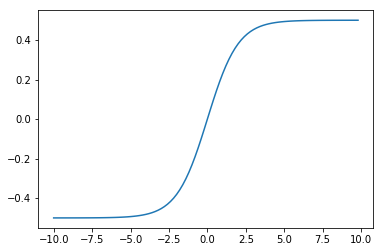

In [97]:
sigmoid_exponent = 1
rect_slope = 1
func = sigmoid
a = np.linspace(-10, 10, 100, False)
b = func(a,sigmoid_exponent)
plt.plot(a,b)

In [98]:
# Mask parameters
M = 2*np.random.rand(np.shape(feature_matrix)[1],N)-1
Mb = 2*np.random.rand(1,N)-1
print(np.shape(M))
print(np.shape(Mb))
print(np.min(M), np.max(M))
print(np.min(Mb), np.max(Mb))


(9, 200)
(1, 200)
-0.9996991010095919 0.9959010262430648
-0.997807102145692 0.9595629400774719


In [ ]:
# Train set features
# print(np.min(features_A), np.max(features_A))

In [ ]:
# # Create ESN
# ESN = np.ones((np.shape(features_A)[0],N), dtype=np.double)
# IN = np.matmul(features_A, M) + np.repeat(Mb, np.shape(features_A)[0], axis=0)
# print(np.shape(IN))
# print(np.min(IN), np.max(IN))
# p = np.zeros((1,N),dtype=np.double)
# for i in range(np.shape(features_A)[0]):
#     i
#     in_val = scale*IN[i,:]+p*mem
#     ESN[i,:] = func(in_val, sigmoid_exponent) #Apply transform
#     p = np.copy(np.roll(ESN[i,:],1))

In [99]:
# Create ESN 
def feedESN(features, mask, mask_bias, scale, mem):
    ESN = np.ones((np.shape(features)[0],N), dtype=np.double)
    IN = np.matmul(features, M) + np.repeat(Mb, np.shape(features)[0], axis=0)
    print(np.shape(IN))
    print(np.min(IN), np.max(IN))
    p = np.zeros((1,N),dtype=np.double)
    for i in range(np.shape(features)[0]):
        i
        in_val = scale*IN[i,:]+p*mem
        ESN[i,:] = func(in_val, sigmoid_exponent) #Apply transform
        p = np.copy(np.roll(ESN[i,:],1))
    return ESN

In [100]:
#Loop realisations
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

for train_index, test_index in gkf.split(X_shuffled, y_shuffled, groups_shuffled):
#     print("TRAIN:", train_index, "TEST:", test_index)
#     print("pTRAIN:", patient[train_index], "pTEST:", patient[test_index])
    X_train, X_test = X_shuffled[train_index], X_shuffled[test_index]
    y_train, y_test = y_shuffled[train_index], y_shuffled[test_index]
    ESN = feedESN(X_train, M, Mb, scale, mem)
    ESNinv = np.linalg.pinv(ESN)
    print(np.shape(ESNinv))
    w = np.matmul(ESNinv, y_train)

    ESNtest = feedESN(X_test, M, Mb, scale, mem)
    Y_pred = (np.matmul(ESNtest,w))

#     cm = confusion_matrix(y_test, Y_pred)
#     print(cm[0,0],cm[0,1])
#     print(cm[1,0],cm[1,1])
    print('auc: ', roc_auc_score(y_test, Y_pred))

TRAIN: [     0      1      3 ... 188450 188451 188452] TEST: [     2     12     14 ... 188397 188433 188444]
pTRAIN: [[   0]
 [   0]
 [   0]
 ...
 [4999]
 [4999]
 [4999]] pTEST: [[   0]
 [   0]
 [   0]
 ...
 [4997]
 [4998]
 [4999]]
(169607, 200)
-762.0077562374921 866.4314926387925
(200, 169607)
(18846, 200)
-618.1988683934178 732.8961841772964
0.7348272914886077
TRAIN: [     0      1      2 ... 188450 188451 188452] TEST: [     8     19     20 ... 188420 188425 188448]
pTRAIN: [[   0]
 [   0]
 [   0]
 ...
 [4999]
 [4999]
 [4999]] pTEST: [[   0]
 [   0]
 [   0]
 ...
 [4997]
 [4998]
 [4999]]
(169607, 200)
-762.0077562374921 866.4314926387925
(200, 169607)
(18846, 200)
-611.0795932211054 583.8739878540151
0.6936029772060326
TRAIN: [     0      1      2 ... 188450 188451 188452] TEST: [    17     24     48 ... 188426 188429 188441]
pTRAIN: [[   0]
 [   0]
 [   0]
 ...
 [4999]
 [4999]
 [4999]] pTEST: [[   0]
 [   1]
 [   1]
 ...
 [4998]
 [4998]
 [4998]]
(169607, 200)
-762.0077562374921 866

### Report

In [ ]:
# Report config
if norm_feat_pat:
    print ("norm")
    print(scaler)
else: 
    print("not norm")
print("func: ", func)
print("func_argument: ", sigmoid_exponent, rect_slope)
print("mem: ", mem)
print("scale: ", scale)
print("auc: ", auc)
